# Problem1

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

In [8]:
# Load the ratings data
ratings_cols = ['user_id', 'item_id', 'rating', 'timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')

ratings.head()


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


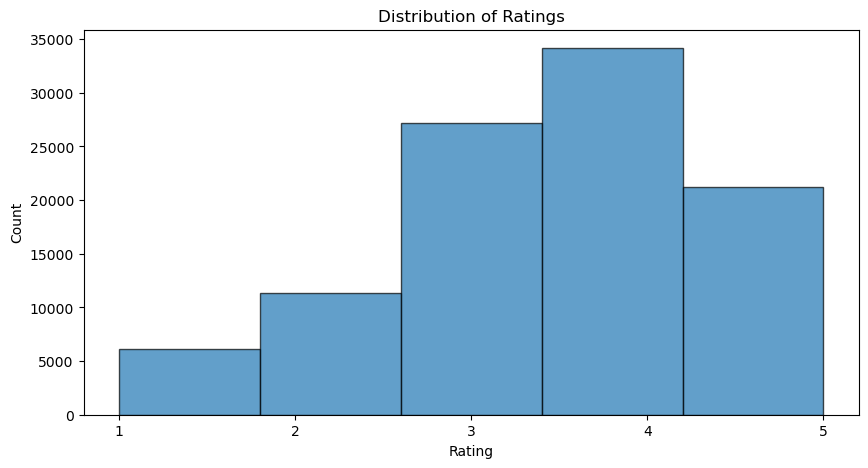

In [9]:
plt.figure(figsize=(10, 5))
plt.hist(ratings['rating'], bins=5, edgecolor='black', alpha=0.7)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks([1, 2, 3, 4, 5])
plt.show()

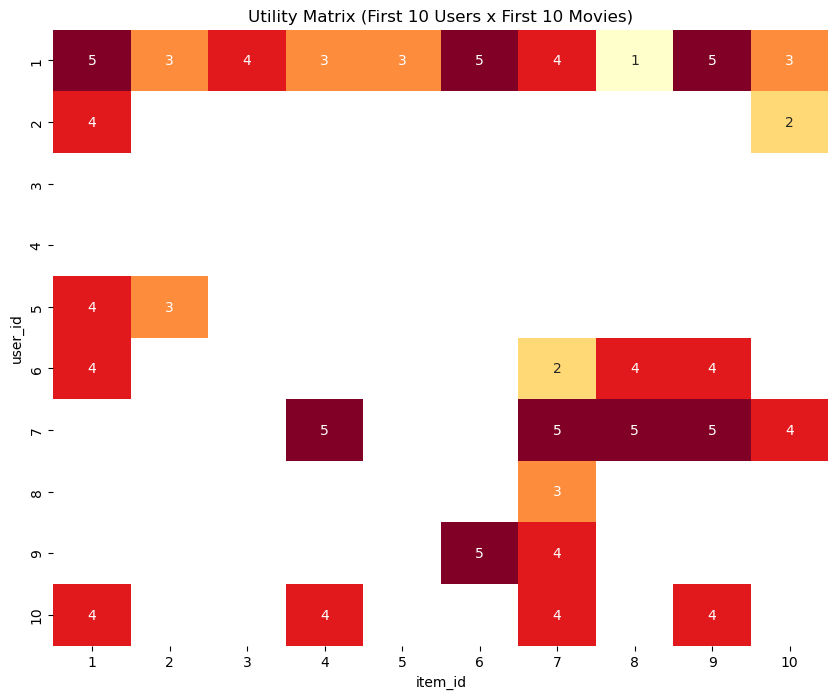

In [10]:
utility_matrix = ratings.pivot(index='user_id', columns='item_id', values='rating')

plt.figure(figsize=(10, 8))
sns.heatmap(utility_matrix.iloc[:10, :10], annot=True, cmap='YlOrRd', cbar=False)
plt.title('Utility Matrix (First 10 Users x First 10 Movies)')
plt.show()

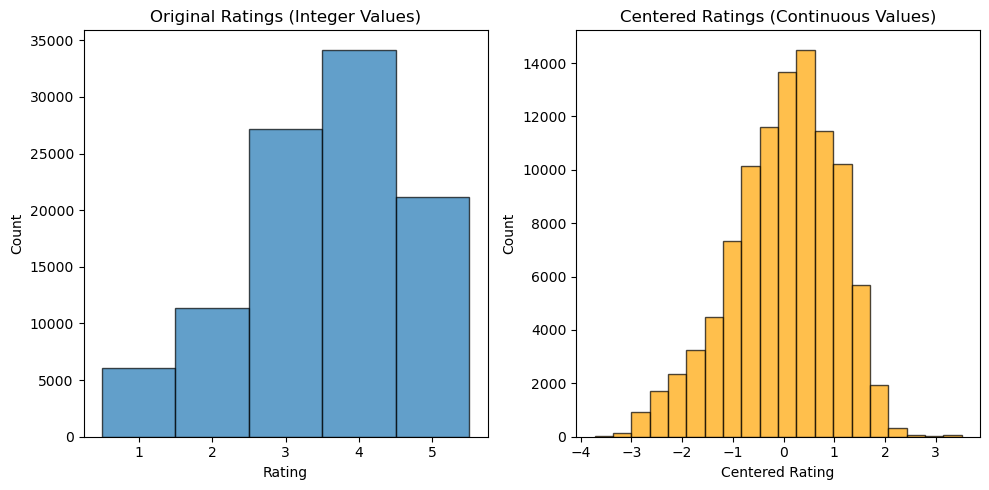

In [11]:
# Calculate user means and center the data
user_means = utility_matrix.mean(axis=1)
centered_matrix = utility_matrix.sub(user_means, axis=0)

# Get the original and centered ratings (excluding NaN values)
original_ratings = utility_matrix.values.flatten()
original_ratings = original_ratings[~np.isnan(original_ratings)]

centered_ratings = centered_matrix.values.flatten()
centered_ratings = centered_ratings[~np.isnan(centered_ratings)]

# Plot the histograms
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(original_ratings, bins=[1, 2, 3, 4, 5, 6], edgecolor='black', align='left', alpha=0.7)
plt.title('Original Ratings (Integer Values)')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks([1, 2, 3, 4, 5])

plt.subplot(1, 2, 2)
plt.hist(centered_ratings, bins=20, edgecolor='black', alpha=0.7, color='orange')
plt.title('Centered Ratings (Continuous Values)')
plt.xlabel('Centered Rating')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [12]:
# Fill NaN values with 0 for similarity calculation
centered_matrix_filled = centered_matrix.fillna(0)

# Compute cosine similarities
cosine_sim = cosine_similarity(centered_matrix_filled)

# Convert to DataFrame for easier handling
cosine_sim_df = pd.DataFrame(cosine_sim, index=utility_matrix.index, columns=utility_matrix.index)


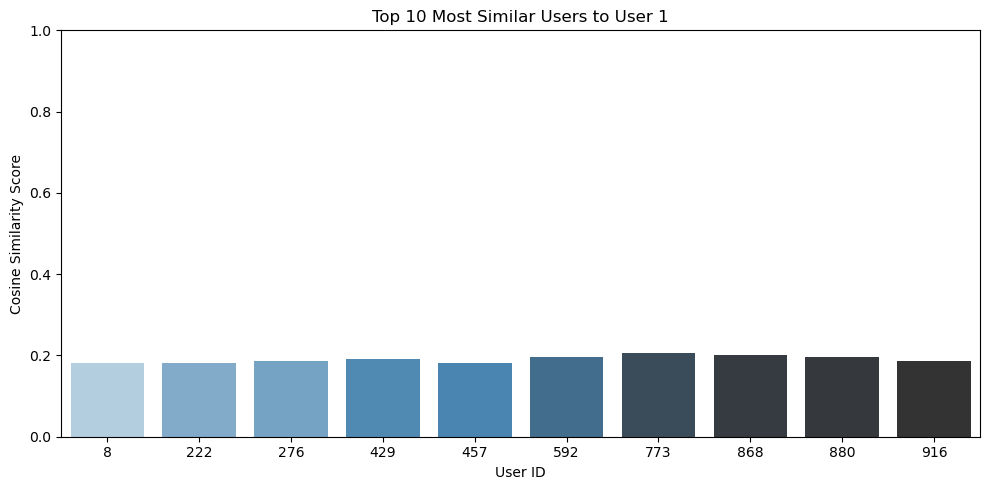

In [13]:
# Get similarities for user 1 (excluding self-similarity)
user1_similarities = cosine_sim_df.loc[1].drop(1)

# Get top 10 similar users
top10_similar_users = user1_similarities.sort_values(ascending=False).head(10).index.tolist()

user1_similarities = cosine_sim_df.loc[1].sort_values(ascending=False)[1:11]  # 排除自己

top10_df = pd.DataFrame({
    'User ID': user1_similarities.index,
    'Similarity Score': user1_similarities.values
})

plt.figure(figsize=(10, 5))
sns.barplot(
    x='User ID',
    y='Similarity Score',
    data=top10_df,
    hue='User ID',
    palette='Blues_d',
    legend=False,
    dodge=False 
)
plt.title('Top 10 Most Similar Users to User 1')
plt.ylabel('Cosine Similarity Score')
plt.ylim(0, 1)
plt.tight_layout() 
plt.show()

In [14]:
# Get ratings for item 508 from similar users (excluding any missing ratings)
item508_ratings = utility_matrix.loc[top10_similar_users, 508].dropna()

# Calculate the predicted rating as the average of similar users' ratings
if len(item508_ratings) > 0:
    predicted_rating = item508_ratings.mean()
else:
    predicted_rating = np.nan  # No similar users rated this item
print(f"The 10 most similar users to user 1 are: {top10_similar_users}")
print(f"The predicted rating for user 1 on item 508 is: {predicted_rating:.2f}")

The 10 most similar users to user 1 are: [773, 868, 592, 880, 429, 276, 916, 222, 457, 8]
The predicted rating for user 1 on item 508 is: 4.20


# Problem2

In [15]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data files
ratings_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')

movies_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
movies = pd.read_csv('ml-100k/u.item', sep='|', names=movies_cols, usecols=range(5), encoding='latin-1')

# Merge ratings with movie information
data = pd.merge(ratings, movies, on='movie_id')

In [16]:
# Create user-item matrix
user_item_matrix = data.pivot_table(index='user_id', columns='movie_id', values='rating')

# Center the ratings by user mean (user-based centering)
user_means = user_item_matrix.mean(axis=1)
centered_matrix = user_item_matrix.sub(user_means, axis=0)

In [17]:
# Get profiles for users 200 and 15
user_200_profile = centered_matrix.loc[200].dropna()
user_15_profile = centered_matrix.loc[15].dropna()

# Get movie 95's ratings from users who rated it
movie_95_ratings = centered_matrix[95].dropna()

In [23]:
# Find common movies between each user and movie 95's raters
common_movies_200 = user_200_profile.index.intersection(movie_95_ratings.index)
common_movies_15 = user_15_profile.index.intersection(movie_95_ratings.index)

# Prepare vectors for similarity calculation
def calculate_similarity(user_profile, movie_vector, common_items):
    user_vector = user_profile[common_items].values.reshape(1, -1)
    movie_vector_values = movie_vector[common_items].values.reshape(1, -1)
    
    cosine_sim = cosine_similarity(user_vector, movie_vector_values)[0][0]
    cosine_dist = 1 - cosine_sim
    return cosine_sim, cosine_dist

cosine_sim_200, cosine_dist_200 = calculate_similarity(user_200_profile, centered_matrix[95], common_movies_200)
cosine_sim_15, cosine_dist_15 = calculate_similarity(user_15_profile, centered_matrix[95], common_movies_15)

from tabulate import tabulate

# Prepare the data
headers = ["User ID", "Cosine Similarity", "Cosine Distance"]
data = [
    ["User 200", f"{cosine_sim_200:.4f}", f"{cosine_dist_200:.4f}"],
    ["User 15", f"{cosine_sim_15:.4f}", f"{cosine_dist_15:.4f}"]
]

# Print the table
print(tabulate(data, headers=headers, tablefmt="grid"))

+-----------+---------------------+-------------------+
| User ID   |   Cosine Similarity |   Cosine Distance |
+===========+=====================+===================+
| User 200  |              0.089  |            0.911  |
+-----------+---------------------+-------------------+
| User 15   |              0.1305 |            0.8695 |
+-----------+---------------------+-------------------+


| User ID    | Cosine Similarity | Cosine Distance |  
|------------|-------------------|------------------|  
| User 200   | 0.089             | 0.911            |  
| User 15    | 0.1305            | 0.8695           |  

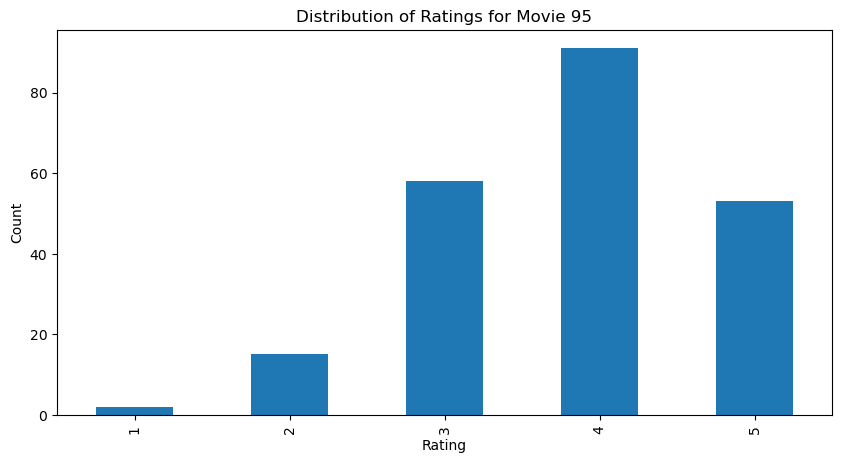

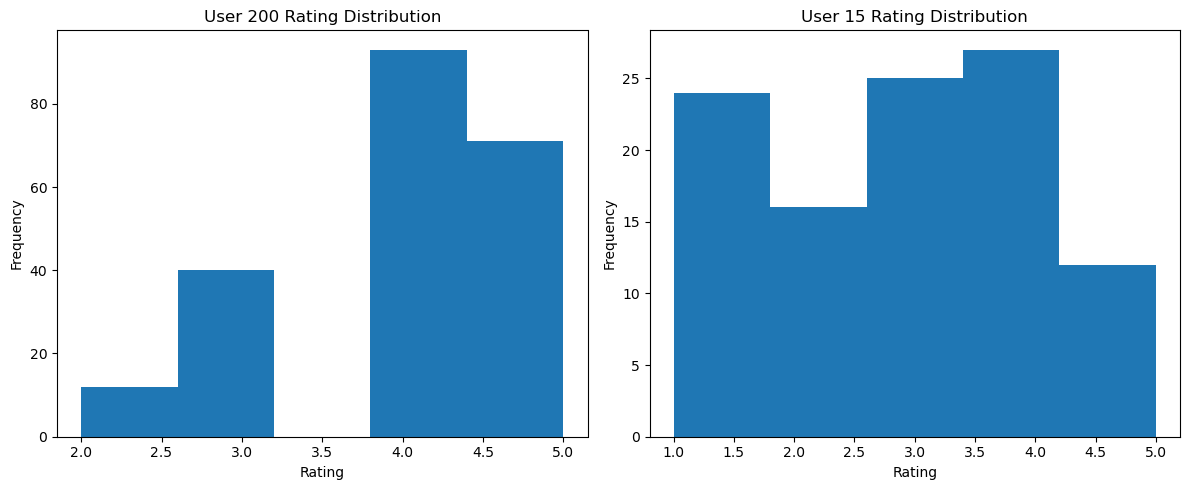

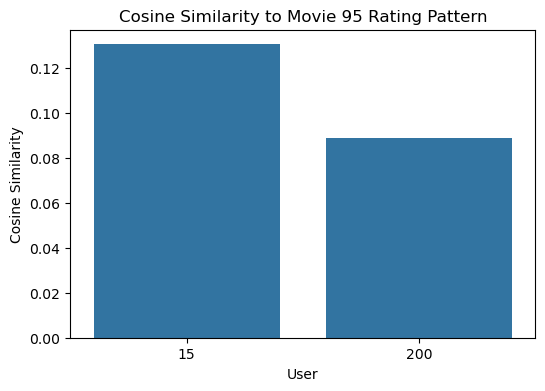

In [24]:
plt.figure(figsize=(10, 5))
ratings[ratings['movie_id'] == 95]['rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Ratings for Movie 95')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# 2. 用户评分分布
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
user_item_matrix.loc[200].dropna().plot(kind='hist', bins=5)
plt.title('User 200 Rating Distribution')
plt.xlabel('Rating')

plt.subplot(1, 2, 2)
user_item_matrix.loc[15].dropna().plot(kind='hist', bins=5)
plt.title('User 15 Rating Distribution')
plt.xlabel('Rating')
plt.tight_layout()
plt.show()

# 3. 相似度比较
similarity_df = pd.DataFrame({
    'User': [200, 15],
    'Cosine Similarity': [cosine_sim_200, cosine_sim_15]
})

plt.figure(figsize=(6, 4))
sns.barplot(x='User', y='Cosine Similarity', data=similarity_df)
plt.title('Cosine Similarity to Movie 95 Rating Pattern')
plt.show()